In [24]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import pandas as pd

#### Download data

In [25]:
# download dataset from https://drive.google.com/file/d/1JILW10sr40CRTLiuA1mf__5GBtMDF9xc/view?usp=sharing
!gdown --id 1JILW10sr40CRTLiuA1mf__5GBtMDF9xc --output vessel_seg.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1JILW10sr40CRTLiuA1mf__5GBtMDF9xc
To: /content/vessel_seg.zip
100% 29.2M/29.2M [00:00<00:00, 148MB/s]


In [26]:
# unzip file
!unzip -q vessel_seg.zip

replace all/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/all/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace all/test/16_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/all/test/._16_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace all/test/17_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/all/test/._17_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace all/test/01_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/all/test/._01_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace all/test/06_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/all/test/._06_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace all/test/07_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#### Data Analysis

In [27]:
# read img and mask
img_paths = glob('all/train/*.tif')
img_path = np.random.choice(img_paths, size=1)[0]
mask_path = img_path.replace('_training.tif', '_manual1.gif')

print('img path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)[:, :, ::-1]
mask = Image.open(mask_path)
mask = np.array(mask)

img path:  all/train/24_training.tif
mask path: all/train/24_manual1.gif


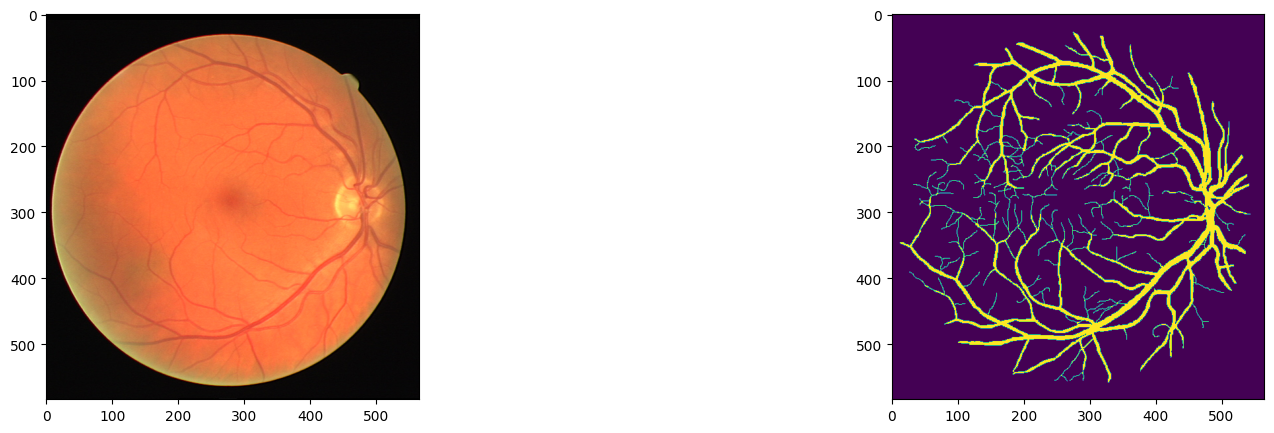

In [28]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [29]:
img.shape, mask.shape

((584, 565, 3), (584, 565))

#### Data processing

In [30]:
IMG_SIZE = 512
BS = 4

In [31]:
class DataGenerator(utils.Sequence):
    def __init__(self, img_paths, batch_size, img_size, shuffle=True, mode='train', aug=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.mode = mode
        self.img_paths = img_paths
        self.mask_paths = [p.replace('_training.tif', '_manual1.gif') for p in self.img_paths]
        self.aug = aug
        self.indexes = np.arange(len(self.mask_paths))
        # data augmentation
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Affine(
                rotate=(-10, 10), # random rotate -45 ~ +45 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        if self.mode != 'test':
            return X, y
        else:
            return X

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)[:, :,::-1]
            img = self.preprocess(img)
            x[i] = img
            if self.mode != 'test':
                mask = np.array(Image.open(mask_path))
                mask = self.preprocess(mask)
                y[i] = np.expand_dims(mask, axis=-1)
        return x, y

        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y

    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [32]:
all_paths = glob('all/train/*.tif')
test_paths = sorted(glob('all/test/*.tif'))
train_paths, val_paths = train_test_split(all_paths, test_size=0.2)

train_gen = DataGenerator(train_paths, BS, IMG_SIZE, shuffle=True, mode='train', aug=True)
val_gen = DataGenerator(val_paths, BS, IMG_SIZE, shuffle=False, mode='val')
test_gen = DataGenerator(test_paths, BS, IMG_SIZE, shuffle=False, mode='test')

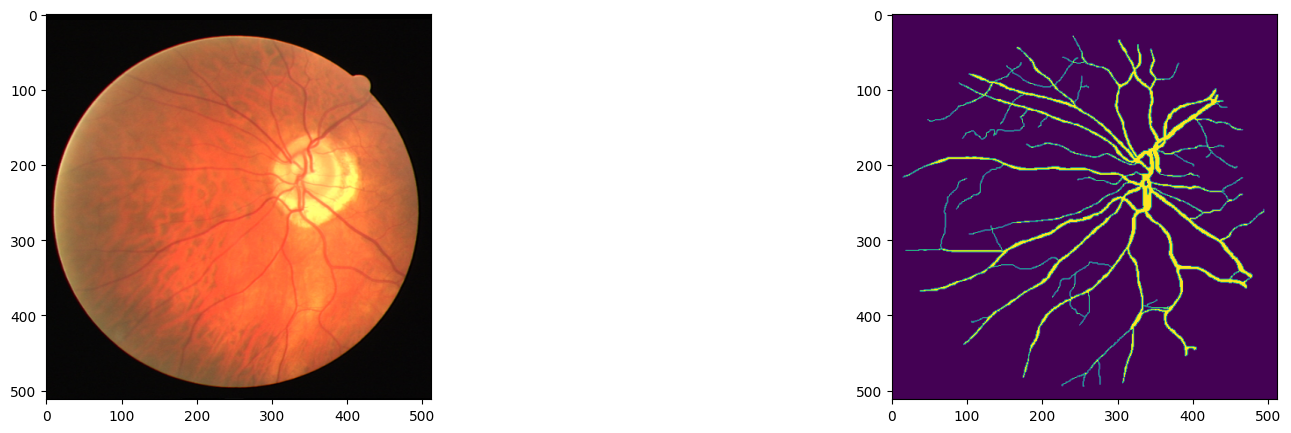

In [33]:
# Check output

batch_x, batch_y = train_gen[0]

batch_i = np.random.choice(len(batch_x))
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(batch_x[batch_i], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(batch_y[batch_i, :, :, 0])
plt.show()

#### Build model

In [34]:
# TODO
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
c1 = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = layers.MaxPool2D(strides=(2,2))(c1)
c2 = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D(strides=(2,2))(c2)
c3 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D(strides=(2,2))(c3)
c4 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = layers.concatenate([layers.UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = layers.Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = models.Model(input_layer, output_layer)

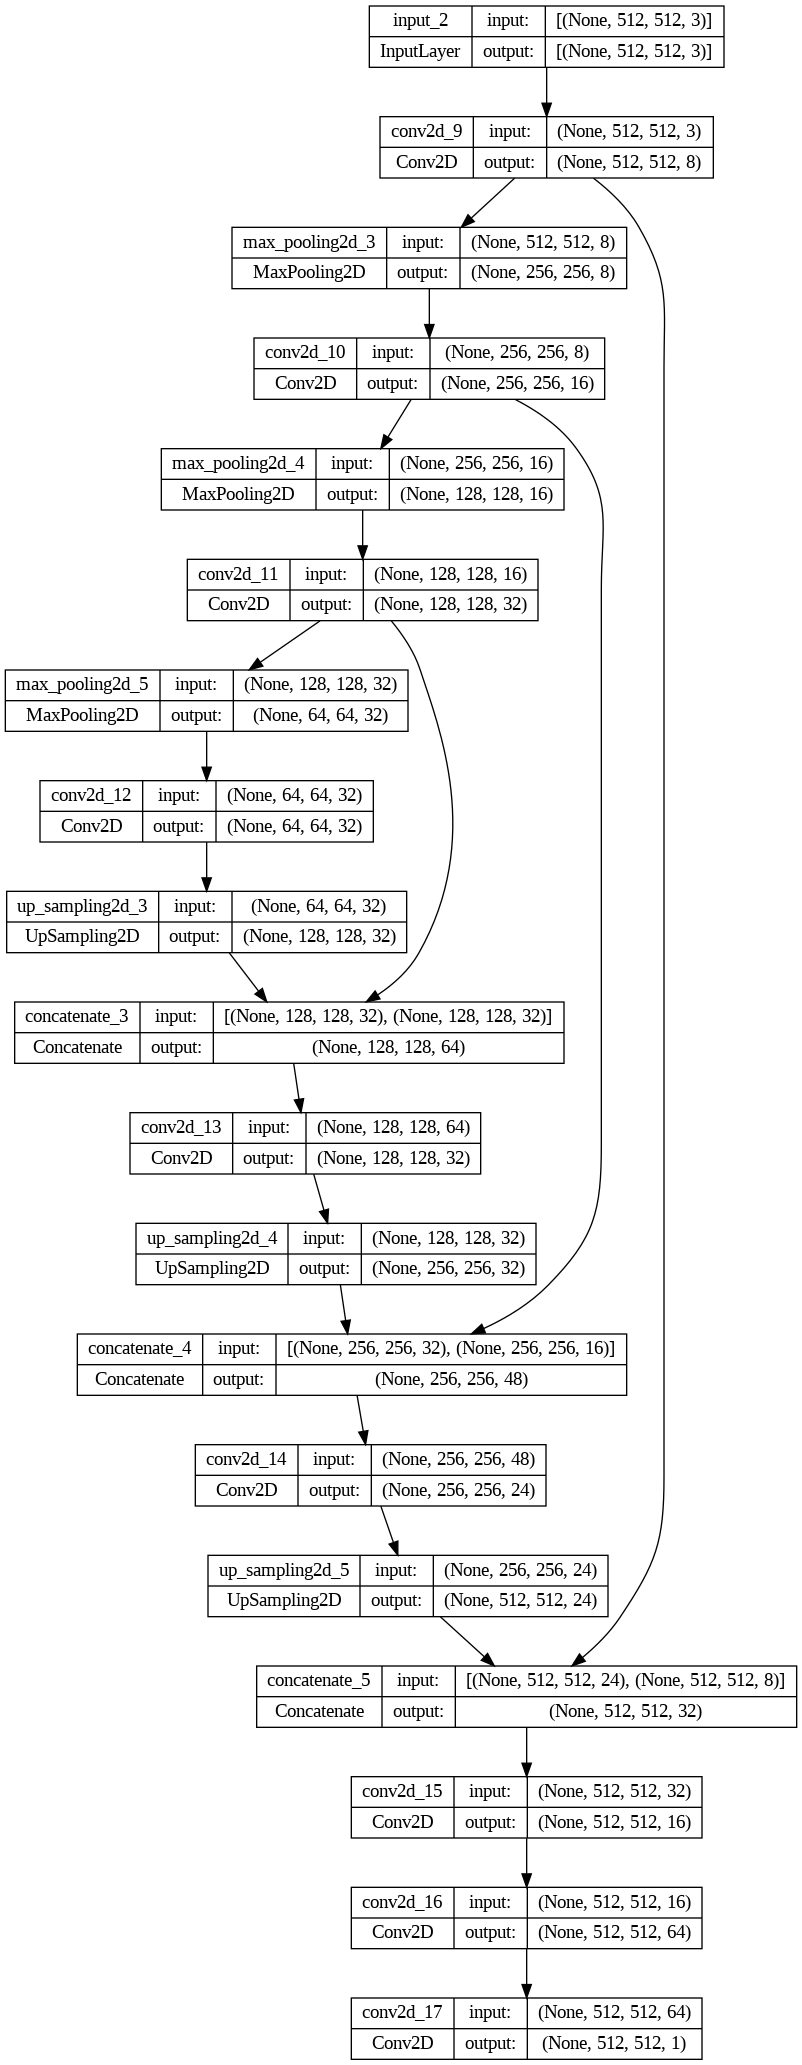

In [35]:
utils.plot_model(model, show_shapes=True)

#### Training

In [36]:
# Customize Dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [37]:
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=[dice_coef])

In [38]:
weight_saver = callbacks.ModelCheckpoint('seg.h5', monitor='val_loss', save_best_only=True)

In [39]:
logs = model.fit(train_gen,
                 validation_data = val_gen,
                 epochs=350,
                 callbacks = [weight_saver])

Epoch 1/350
4/4 [==============================] - 4s 255ms/step - loss: 0.6825 - dice_coef: 0.1481 - val_loss: 0.6462 - val_dice_coef: 0.1367
Epoch 2/350
4/4 [==============================] - 1s 142ms/step - loss: 0.6168 - dice_coef: 0.1409 - val_loss: 0.5270 - val_dice_coef: 0.1197
Epoch 3/350
4/4 [==============================] - 1s 143ms/step - loss: 0.4827 - dice_coef: 0.1087 - val_loss: 0.4147 - val_dice_coef: 0.0487
Epoch 4/350
4/4 [==============================] - 1s 120ms/step - loss: 0.4535 - dice_coef: 0.0367 - val_loss: 0.4436 - val_dice_coef: 0.0232
Epoch 5/350
4/4 [==============================] - 1s 143ms/step - loss: 0.4307 - dice_coef: 0.0415 - val_loss: 0.3918 - val_dice_coef: 0.0567
Epoch 6/350
4/4 [==============================] - 1s 137ms/step - loss: 0.4052 - dice_coef: 0.0755 - val_loss: 0.3861 - val_dice_coef: 0.0789
Epoch 7/350
4/4 [==============================] - 1s 193ms/step - loss: 0.3959 - dice_coef: 0.0844 - val_loss: 0.3636 - val_dice_coef: 0.0661

#### Evaluate

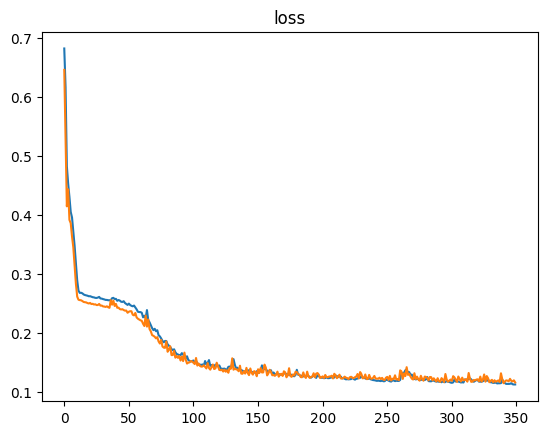

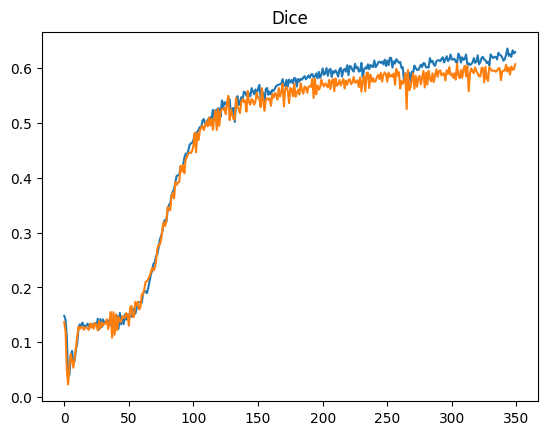

In [40]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.show()
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.show()

In [41]:
model_final = models.load_model('seg.h5', compile=False)

0
1/1 [==============================] - 0s 121ms/step


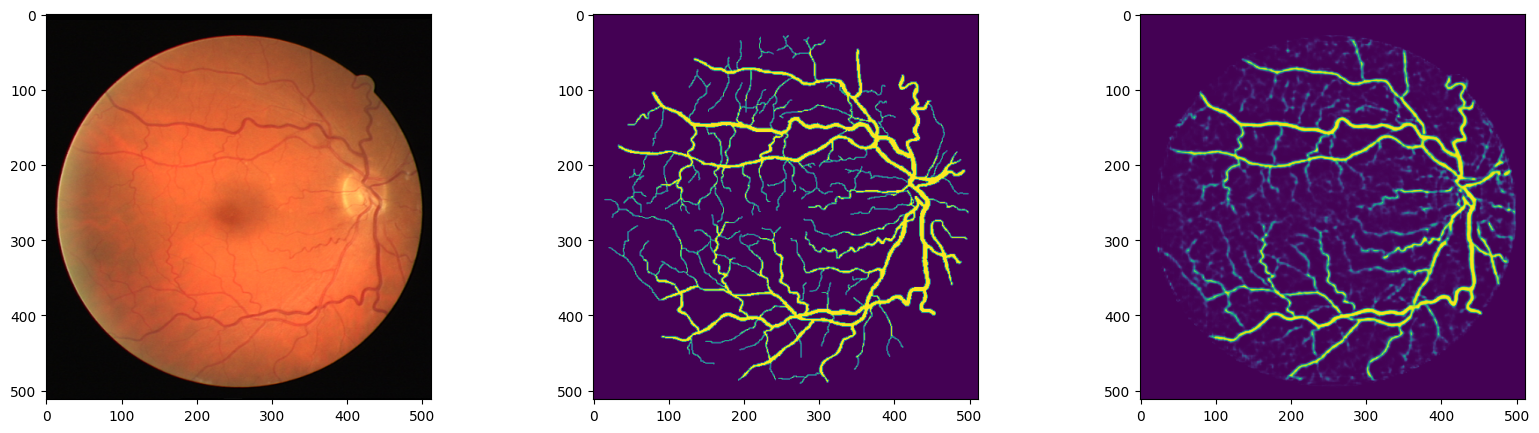

In [42]:
# Sample 1 batch
batch_idx = np.random.randint(len(val_gen))
print(batch_idx)
data = val_gen[batch_idx]
imgs, mask = data # (bs, 512, 512, 3), (bs, 512, 512, 1)
mask_pred = model_final.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.imshow(imgs[img_idx])

# show ground truth & model prediction
plt.subplot(1, 3, 2)
plt.imshow(mask[img_idx, :, :, 0])
plt.subplot(1, 3, 3)
plt.imshow(mask_pred[img_idx, :, :, 0])
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [43]:
# Displayed with different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[3.97189361e-13, 2.83432674e-13, 1.50610061e-13, ...,
        6.31122352e-14, 1.03955204e-11, 7.40979146e-07],
       [1.80894525e-13, 1.15844712e-13, 5.32055716e-14, ...,
        8.54118615e-14, 1.25897895e-11, 8.23163646e-07],
       [9.34392537e-14, 5.26565587e-14, 2.02687225e-14, ...,
        1.20477372e-13, 1.57249803e-11, 9.41931148e-07],
       ...,
       [1.80944899e-13, 2.07443275e-13, 2.20878247e-13, ...,
        1.40125955e-08, 2.59904937e-07, 2.10679864e-04],
       [3.43439138e-10, 3.90648958e-10, 4.47002158e-10, ...,
        9.28885584e-07, 5.25399764e-06, 1.20957347e-03],
       [1.59317260e-05, 1.67766884e-05, 1.76057965e-05, ...,
        8.32771941e-04, 2.28768028e-03, 2.84362715e-02]], dtype=float32)

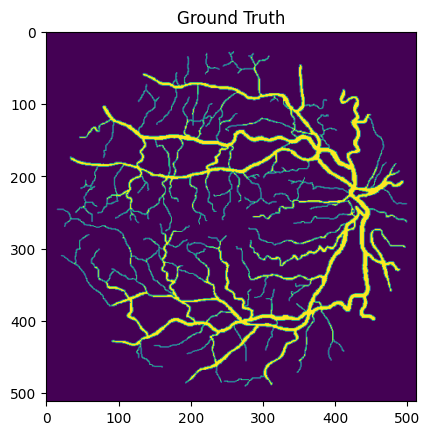

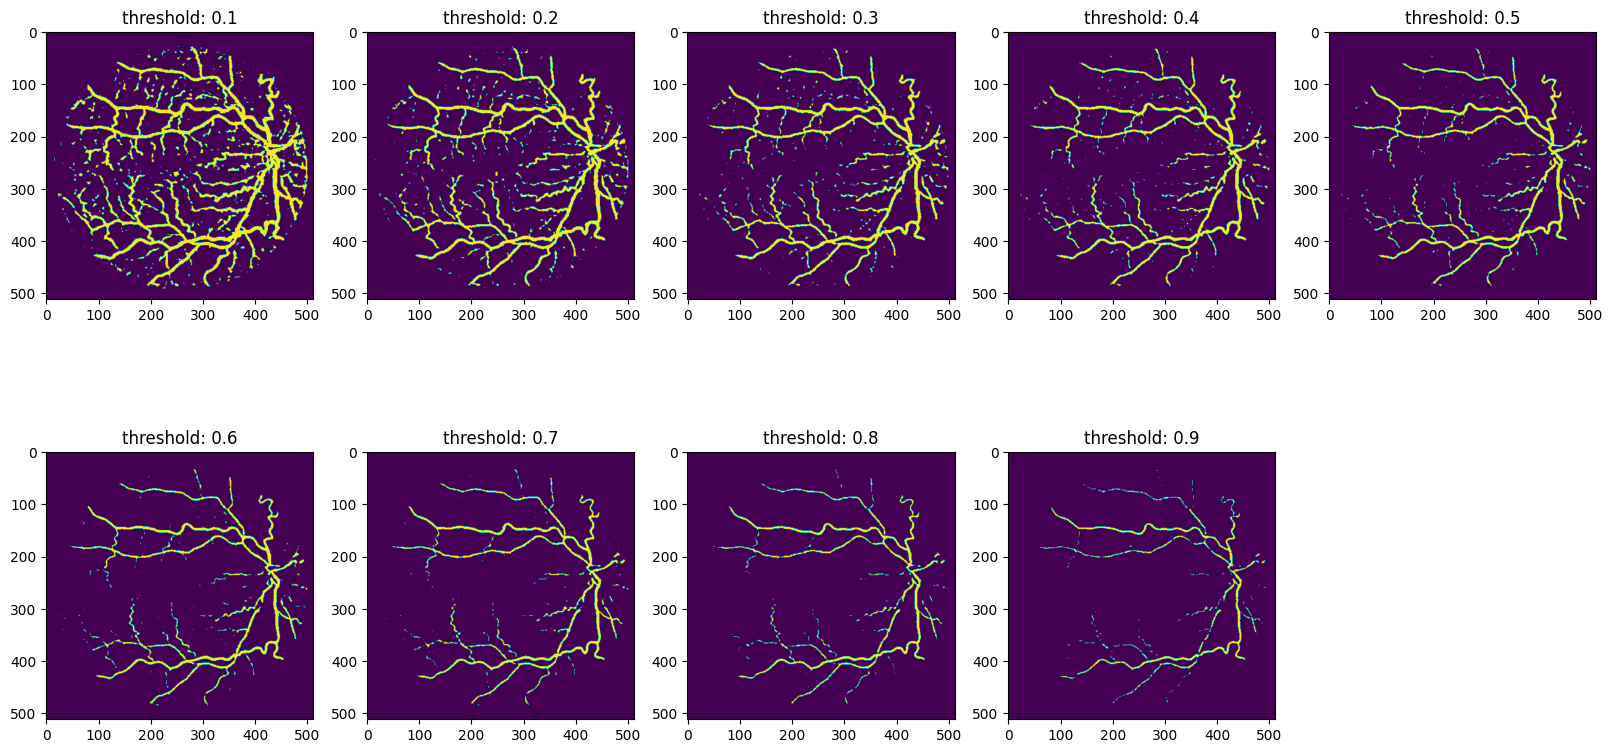

In [44]:
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()

In [45]:
# make prediction
threshold = 0.5
outputs = []
for i in range(len(test_gen)):
    x_test = test_gen[i]
    y_preds = model_final.predict(x_test)
    y_preds[y_preds <= threshold] = 0
    y_preds[y_preds > threshold] = 1
    for y_pred in y_preds:
        dots = np.where(y_pred.flatten() == 1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev +1):
                run_lengths.extend((b+1,0))
            run_lengths[-1] += 1
            prev = b
        output = ' '.join([str(r) for r in run_lengths])
        outputs.append(output)

1/1 [==============================] - 0s 23ms/step


In [46]:
df = pd.DataFrame(columns=['Id', 'Predicted'])
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv('submission.csv', index=None)
df

,Id,Predicted
0,0,15621 2 16134 2 16163 1 16646 2 16675 1 17159 ...
1,1,15103 3 15615 4 15633 1 16128 3 16145 3 16599 ...
2,2,14091 1 14601 4 15113 2 15621 3 16079 1 16132 ...
3,3,15610 2 16122 3 16635 3 16689 1 17147 4 17201 ...
4,4,17187 1 17699 3 18211 3 18685 1 18723 2 19233 ...
5,5,18629 1 19141 2 19653 3 20166 4 20270 3 20678 ...
6,6,16103 1 16143 1 16613 6 16655 2 17125 8 17167 ...
7,7,15591 4 15633 4 16104 4 16145 4 16616 4 16657 ...
8,8,15126 2 15638 2 16148 3 16658 4 17169 5 17653 ...
9,9,17113 4 17153 1 17624 6 17665 2 18137 6 18177 ...


In [47]:
print(utils.Sequence)

<class 'keras.utils.data_utils.Sequence'>


In [48]:
type(utils.Sequence)

type